# Import Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_predict

warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)
plt.style.use('ggplot')

# Load Data

In [3]:
df = pd.read_csv('data/sentiment_per_month_decomposed.csv', index_col=['date'], parse_dates=['date'])
df = df[['trend']]
df = df.dropna()
df

,trend
date,
2005-08-31,0.640232
2005-09-30,0.640232
2005-10-31,0.640232
2005-11-30,0.712317
2005-12-31,0.783746
...,...
2021-06-30,0.461904
2021-07-31,0.466932
2021-08-31,0.476577


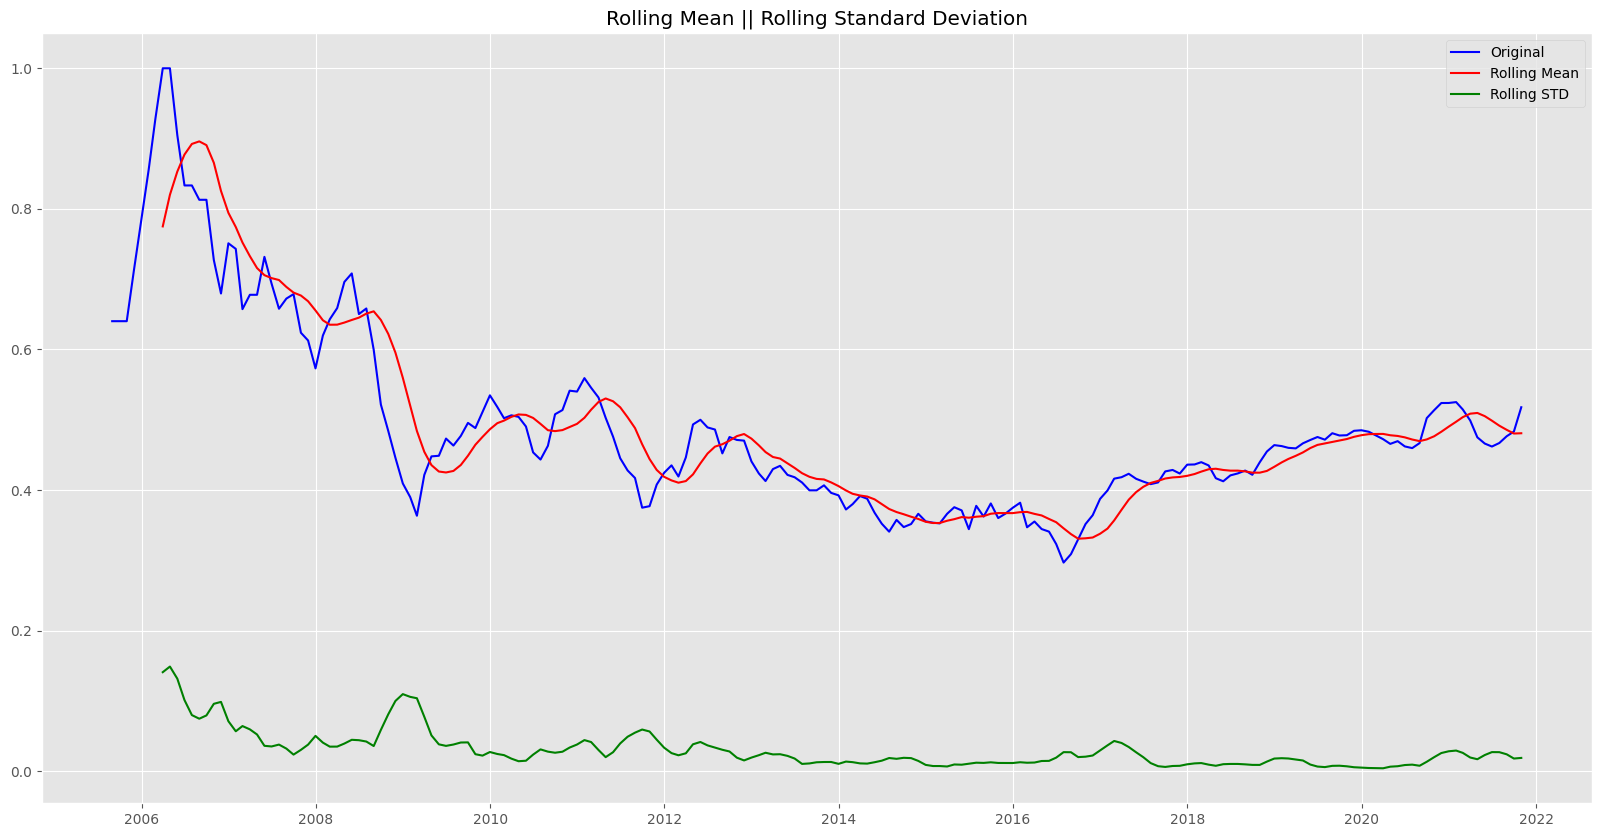

In [4]:
# Visualise if the data is stationary or not
rolling_mean = df.rolling(window = 8).mean()
rolling_std = df.rolling(window = 8).std()

# ploting the data
plt.plot(df, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'green', label = 'Rolling STD')
plt.legend(loc = 'best')
plt.title('Rolling Mean || Rolling Standard Deviation')
plt.show()

In [5]:
# getting the result of:
# >> ADF Statistic
# >> P-Values
# >> Critical Values
result = adfuller(df['trend'])
print('ADF Statistic: {}'.format(result[0]))
print('P-Values: {}'.format(result[1]))

print('Critical Values: ')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -3.5688588188833665
P-Values: 0.006385061091704007
Critical Values: 
	1%: -3.4672111510631
	5%: -2.877734766803841
	10%: -2.575403364197531


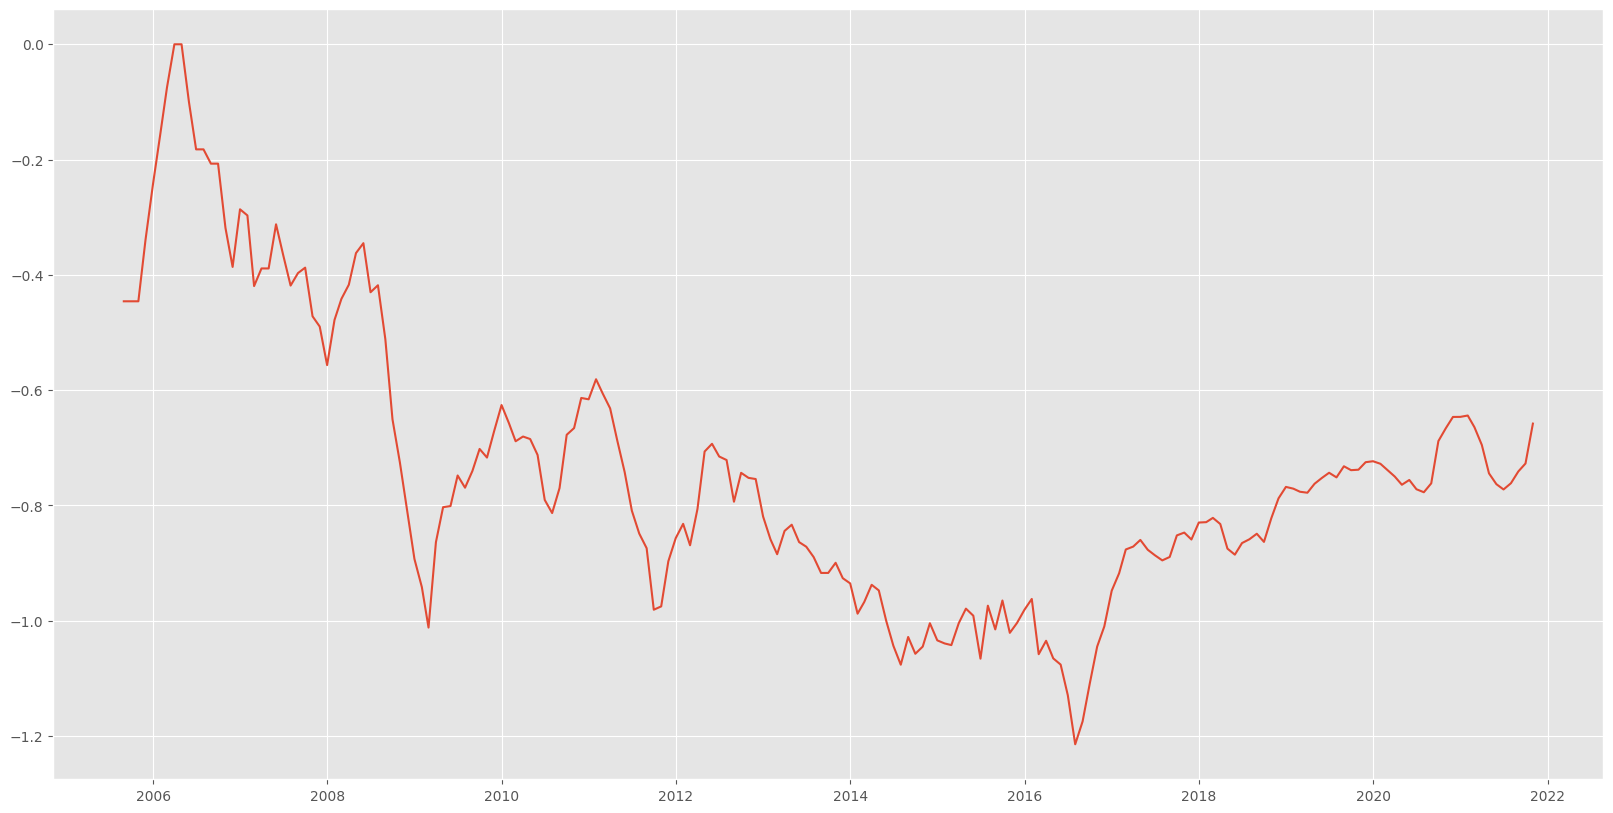

In [6]:
# Taking the log of the data
df_log = np.log(df)
plt.plot(df_log)

In [7]:
# function to stabilize data
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=8).mean()
    rolling_std = timeseries.rolling(window=8).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='green', label='Rolling STD')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['trend'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

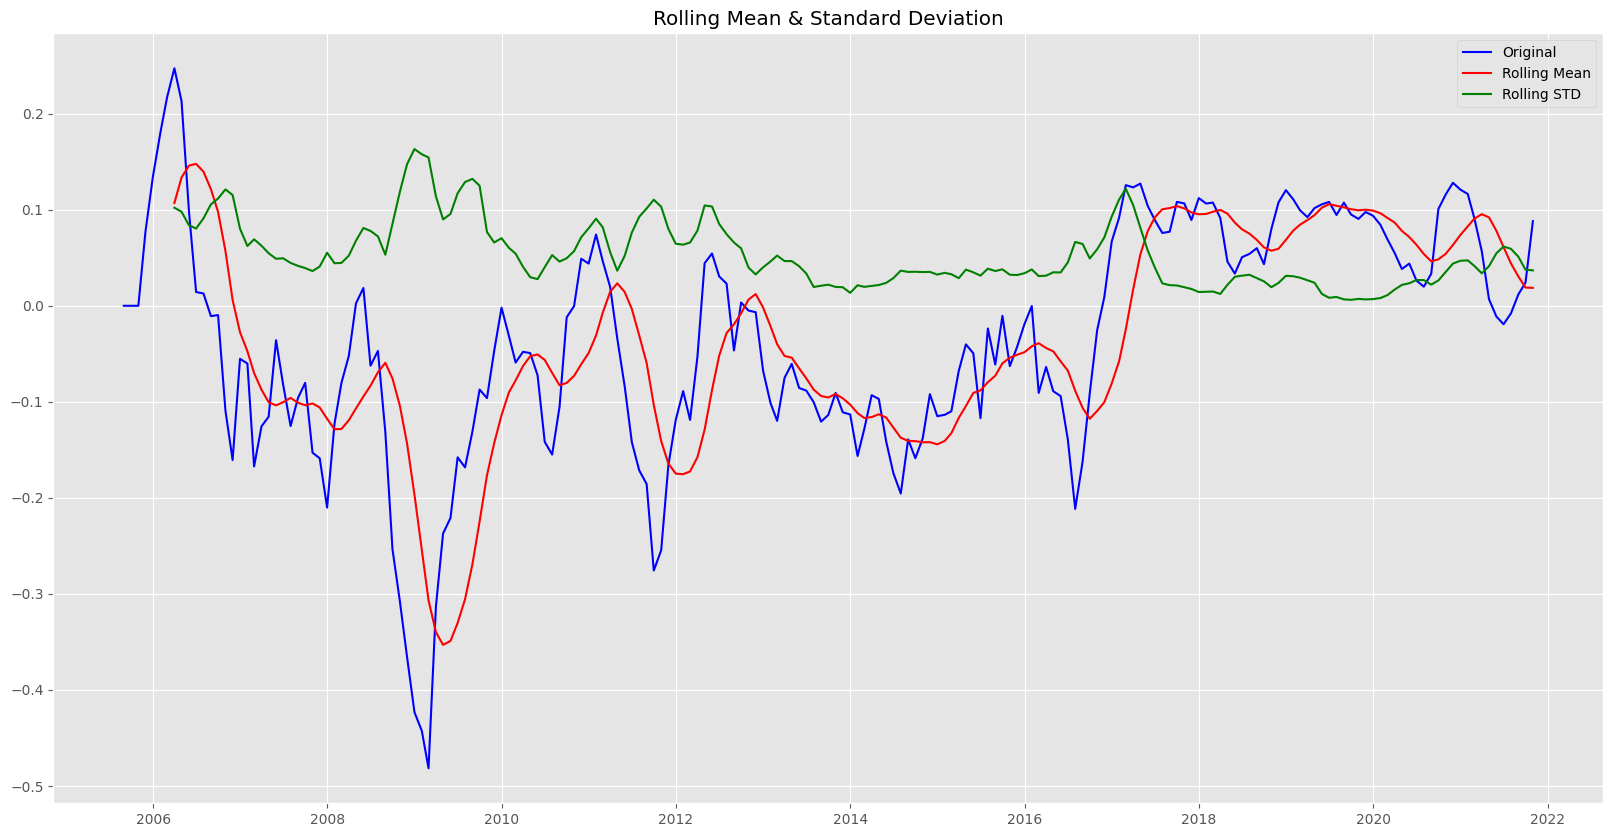

ADF Statistic: -2.059558815065672
p value: 0.2610838977180444
Critical Values:
	1%: -3.466598080268425
	5%: -2.8774669520682674
	10%: -2.5752604356654425


In [8]:
# Exponential decay method
rolling_mean_exp_decay = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)
get_stationarity(df_log_exp_decay)

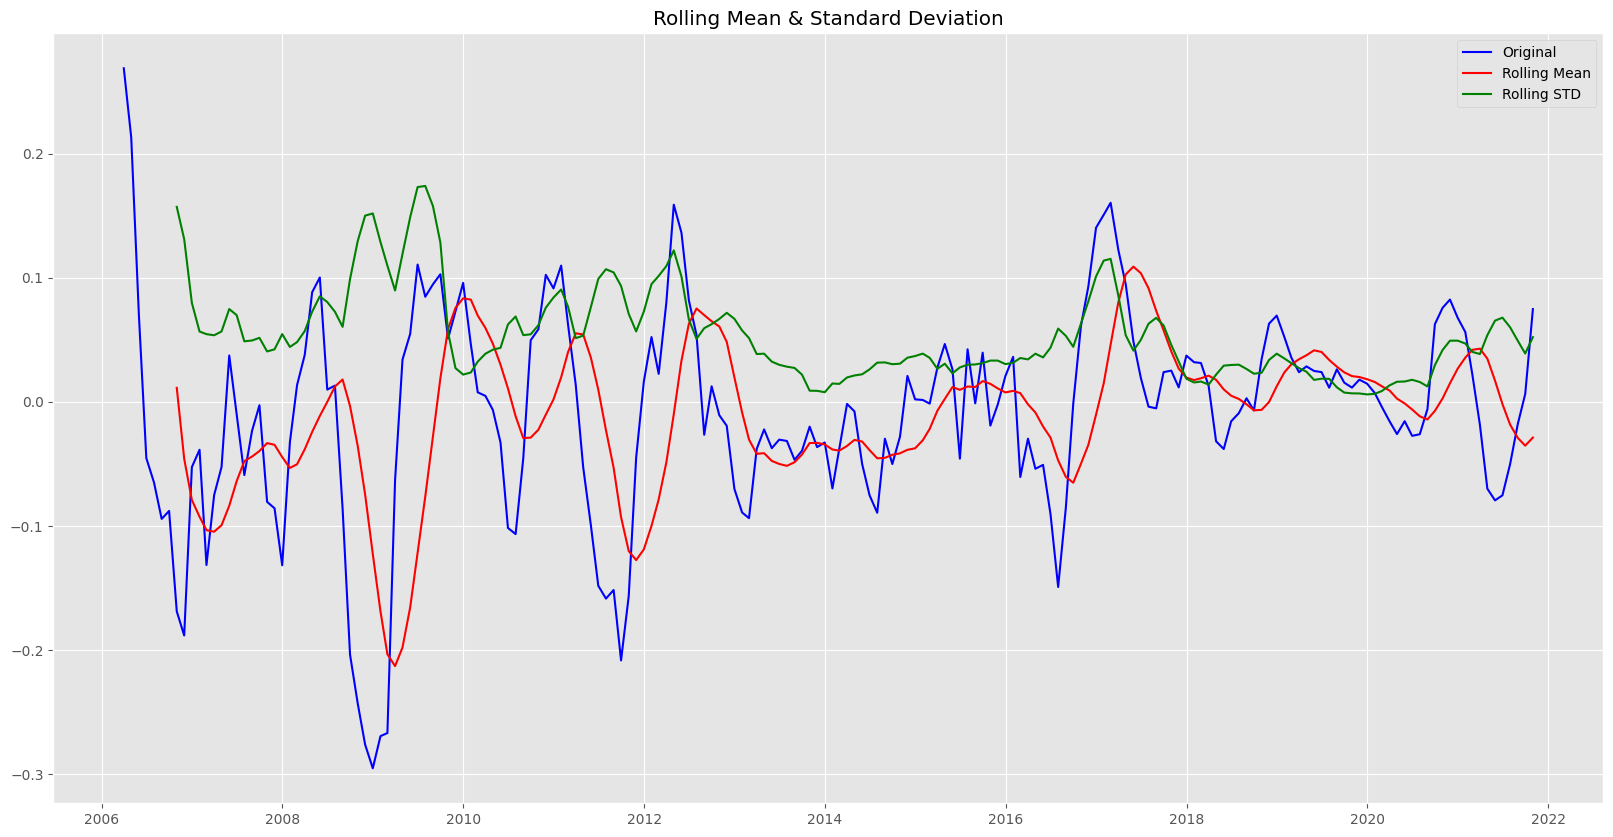

ADF Statistic: -4.237988303511449
p value: 0.0005678475320365501
Critical Values:
	1%: -3.4680615871598537
	5%: -2.8781061899535128
	10%: -2.5756015922004134


In [9]:
# Subtracting the rolling mean
rolling_mean = df_log.rolling(window=8).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean)

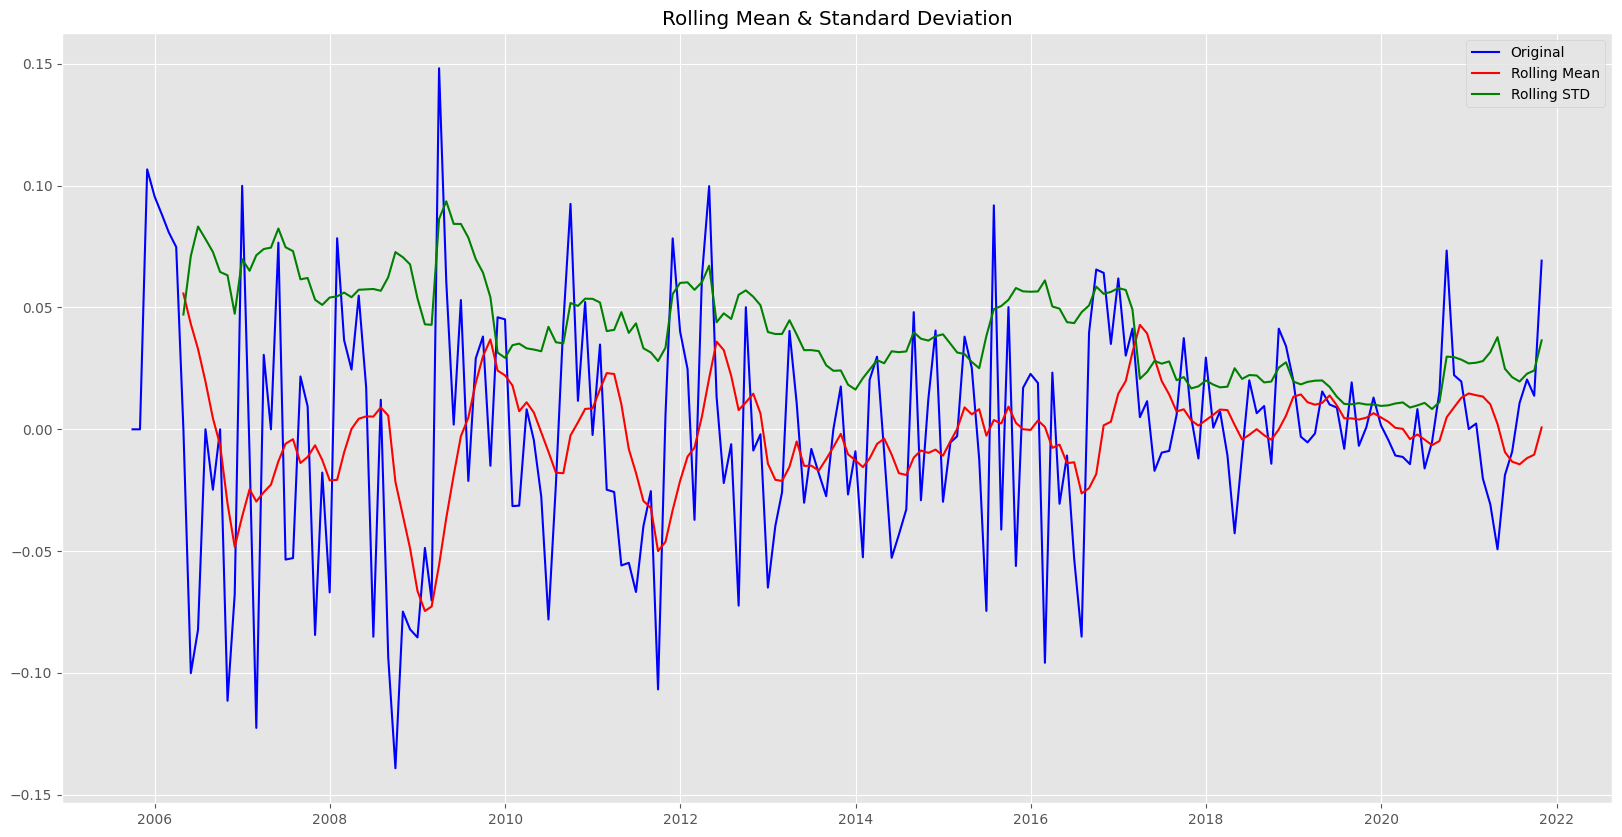

ADF Statistic: -4.458999736807884
p value: 0.00023304815153221098
Critical Values:
	1%: -3.466598080268425
	5%: -2.8774669520682674
	10%: -2.5752604356654425


In [10]:
# The time sifting
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)
get_stationarity(df_log_shift)

# ARIMA

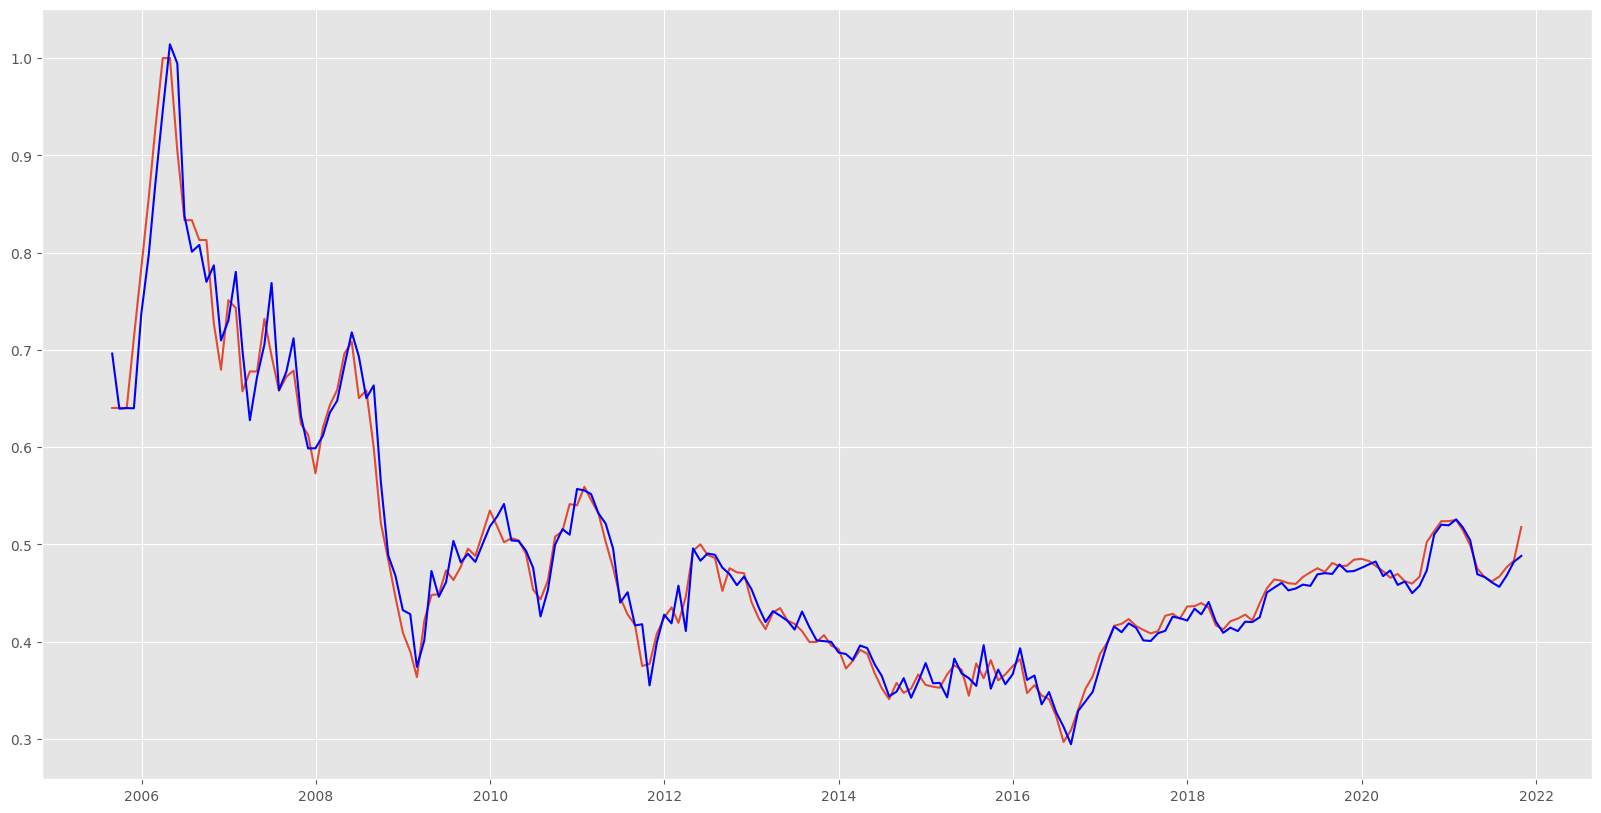

In [11]:
# ARIMA model
model = ARIMA(df, order=(1,0,12), trend='ct', freq='M')
results = model.fit()
plt.plot(df)
plt.plot(results.fittedvalues, color='blue')

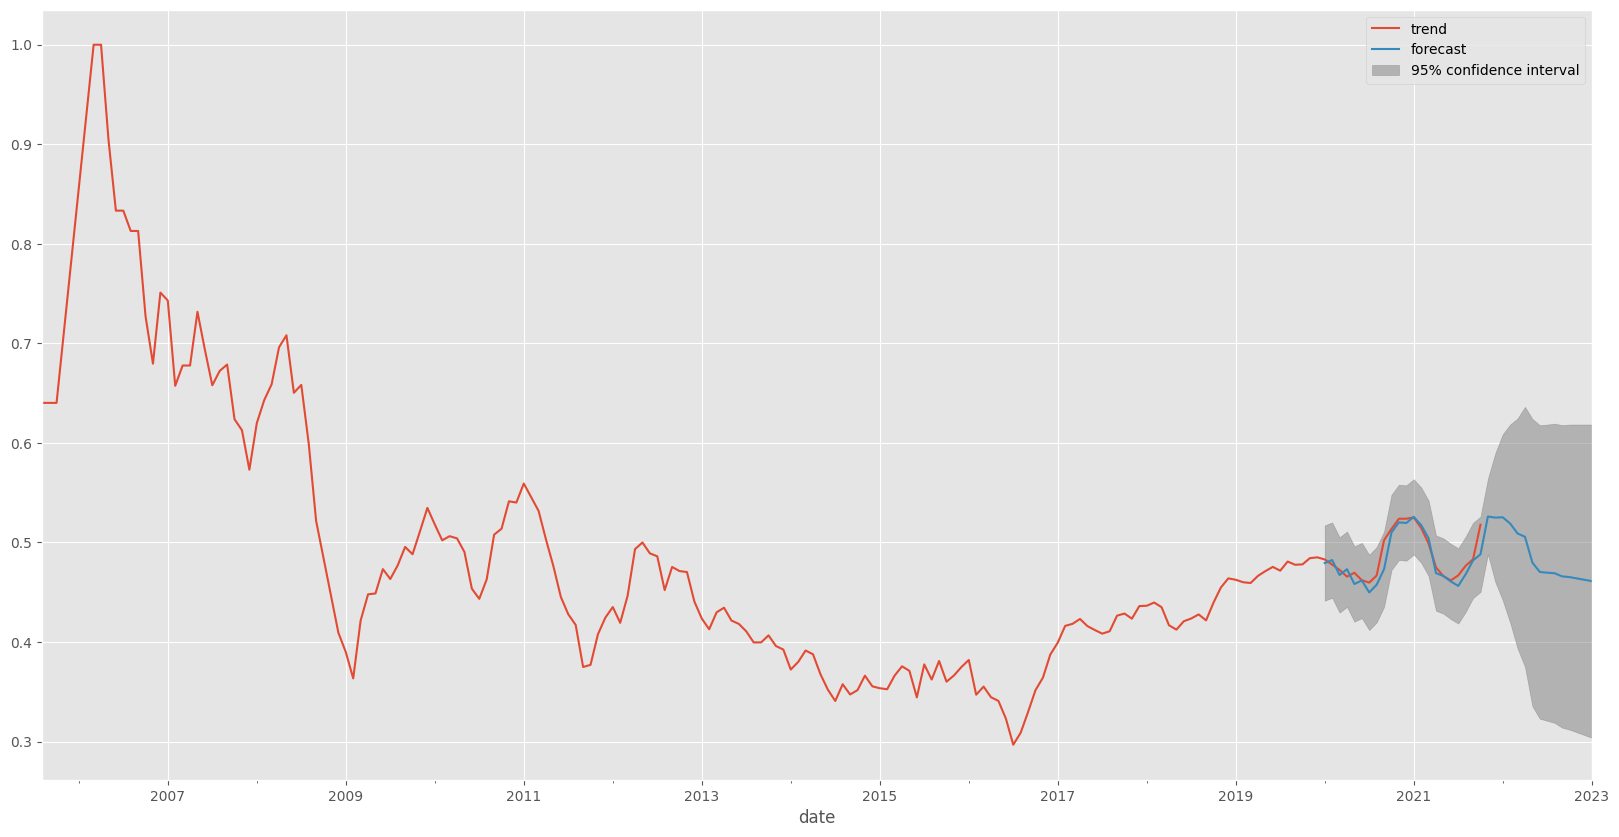

In [13]:
# predictions for the next 12 months
fig, ax = plt.subplots()
ax = df.plot(ax=ax)
plot_predict(results, '2020', '2023', ax=ax)
plt.show()